<a href="https://colab.research.google.com/github/khoji-code/Data-Science-AI-for-Business-Portfolio/blob/main/Projects/Real_Time_IoT_Intrusion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real-Time IoT Intrusion Detection

***

### **Project Overview**

* **Goal:** To develop a machine learning model to accurately classify different types of network attacks in an IoT (Internet of Things) environment.
* **Dataset:** Utilizes the "RT-IoT2022" dataset, which contains a large volume of network traffic data with 83 features.
* **Methodology:** The project includes an advanced exploratory data analysis (EDA) using PCA to visualize the high-dimensional data and assess class separability. A robust preprocessing pipeline is built to handle missing values, scale numerical features, and one-hot encode categorical variables. A LightGBM classifier is trained, with a key focus on addressing the significant class imbalance using class weights.
* **Key Results:** The model achieves outstanding performance, with a macro-averaged F1-score of **0.96** and an overall accuracy of nearly **100%**, demonstrating its effectiveness in distinguishing between various benign and malicious traffic types.

***

### **Purpose**

* **Enhance IoT Security:** To build a reliable and accurate intrusion detection system that can identify and classify network attacks in real-time, thereby protecting IoT devices and networks from malicious activities.
* **Handle Imbalanced Data:** To demonstrate a robust methodology for training a multi-class classifier on a highly imbalanced dataset, which is a common challenge in cybersecurity applications.
* **Provide Actionable Insights:** To offer a detailed performance evaluation through a confusion matrix, which can help security analysts understand the model's strengths and weaknesses for each specific attack type.

### Dataset:
https://archive.ics.uci.edu/dataset/942/rt-iot2022

## IMPORT LIBRARIES

In [ ]:
# Install lightgbm
!pip install -q lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import warnings

# Ignore warnings for a cleaner output.
warnings.filterwarnings('ignore')
print("Libraries imported successfully.")

Libraries imported successfully.


## Load Dataset

In [ ]:
try:
    df = pd.read_csv('/content/drive/MyDrive/IOT/RT_IOT2022.csv')
    print("Dataset loaded successfully. Shape:", df.shape)
except FileNotFoundError:
    print("Error: 'RT_IOT2022.csv' not found. Please upload the file.")
    exit()

Dataset loaded successfully. Shape: (123117, 85)


### Initial Data Cleaning

In [ ]:
# Drop unnamed index column
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Infinite values - Replace with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

print("\nData cleaned. Final shape:", df.shape)


Data cleaned. Final shape: (123117, 84)


## EXPLORATORY DATA ANALYSIS (EDA)

### Target Variable Distribution

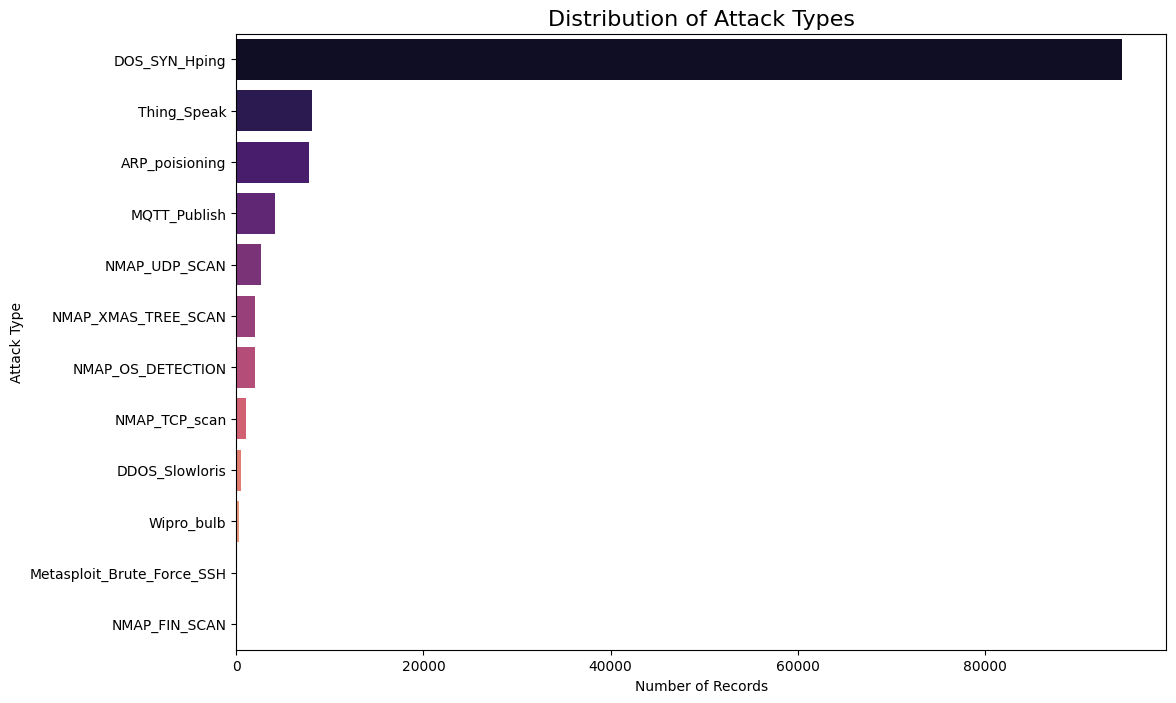

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(y=df['Attack_type'], order=df['Attack_type'].value_counts().index, palette='magma')
plt.title('Distribution of Attack Types', fontsize=16)
plt.xlabel('Number of Records')
plt.ylabel('Attack Type')
plt.show()

### PCA-based Visualization of Class Separability

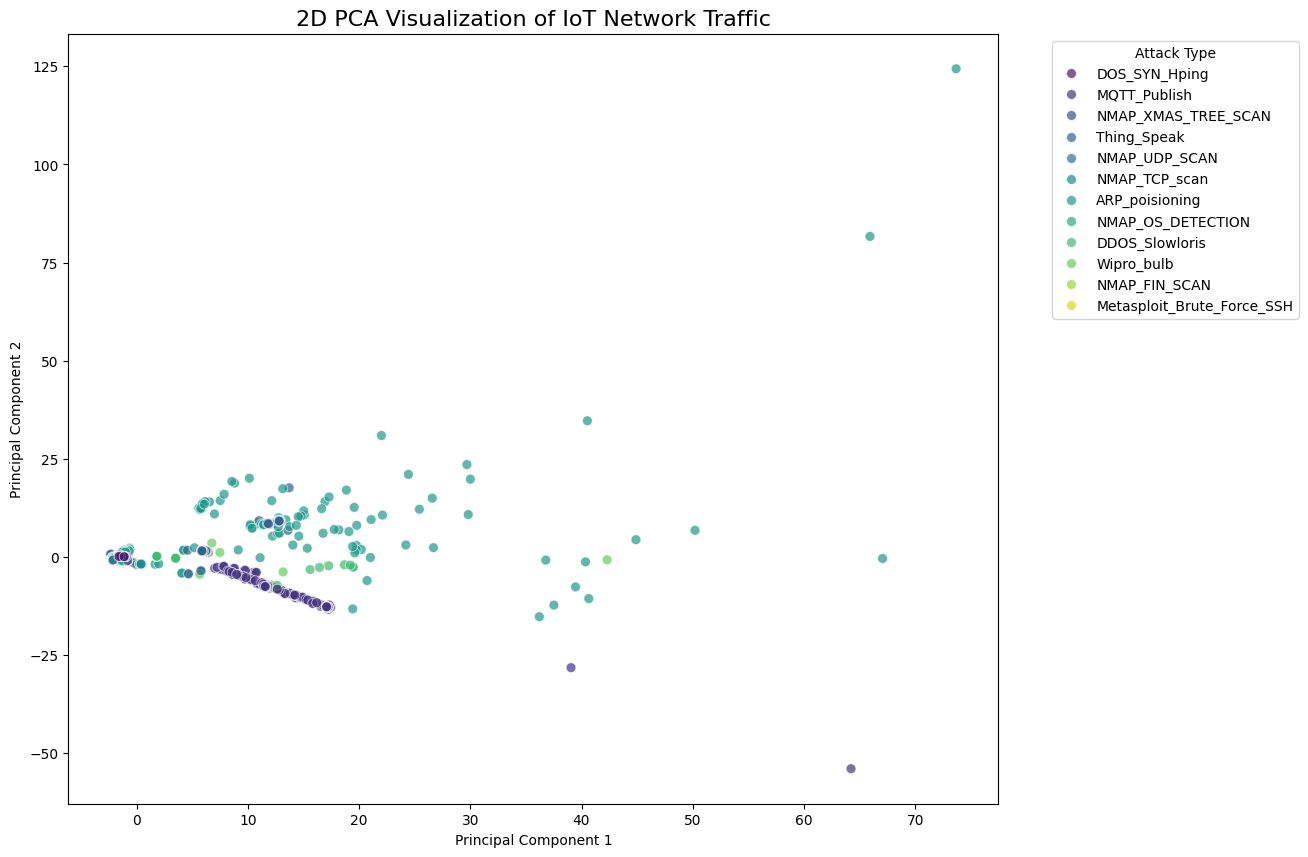

In [ ]:
# 83 features to 2 important Features
sample_df = df.sample(n=5000, random_state=42)
X_sample = sample_df.drop('Attack_type', axis=1)
y_sample = sample_df['Attack_type']

# Preprocessing for PCA
numerical_cols_sample = X_sample.select_dtypes(include=np.number).columns
categorical_cols_sample = X_sample.select_dtypes(include=['object']).columns

# Simple imputation and scaling for the sample
X_sample[numerical_cols_sample] = SimpleImputer(strategy='median').fit_transform(X_sample[numerical_cols_sample])
X_sample[numerical_cols_sample] = StandardScaler().fit_transform(X_sample[numerical_cols_sample])
X_sample = pd.get_dummies(X_sample, columns=categorical_cols_sample)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_sample, palette='viridis', s=50, alpha=0.7)
plt.title('2D PCA Visualization of IoT Network Traffic', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Attack Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## DATA PREPROCESSING & MODELING

In [ ]:
# Feature and Target Separation
X = df.drop('Attack_type', axis=1)
y = df['Attack_type']

# Encode Target Variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_
print(f"\nTarget variable encoded. Mapping: {dict(zip(range(len(class_names)), class_names))}")


Target variable encoded. Mapping: {0: 'ARP_poisioning', 1: 'DDOS_Slowloris', 2: 'DOS_SYN_Hping', 3: 'MQTT_Publish', 4: 'Metasploit_Brute_Force_SSH', 5: 'NMAP_FIN_SCAN', 6: 'NMAP_OS_DETECTION', 7: 'NMAP_TCP_scan', 8: 'NMAP_UDP_SCAN', 9: 'NMAP_XMAS_TREE_SCAN', 10: 'Thing_Speak', 11: 'Wipro_bulb'}


In [ ]:
# Identify Column Types for Pipeline
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"\nIdentified {len(numerical_cols)} numerical and {len(categorical_cols)} categorical features.")


Identified 81 numerical and 2 categorical features.


In [ ]:
# Create Preprocessing Pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Handle Multi-Class Imbalance with Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(f"\nCalculated Class Weights: {class_weights_dict}")

# Create and Train the LightGBM Model Pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(
        objective='multiclass',
        class_weight=class_weights_dict,
        random_state=42
    ))
])

model_pipeline.fit(X_train, y_train)
print("Model training complete.")



Calculated Class Weights: {0: np.float64(1.3238306451612902), 1: np.float64(19.221896955503514), 2: np.float64(0.10838604460760363), 3: np.float64(2.474449804039795), 4: np.float64(273.59166666666664), 5: np.float64(373.07954545454544), 6: np.float64(5.12984375), 7: np.float64(10.234102244389028), 8: np.float64(3.961269305019305), 9: np.float64(5.104322139303482), 10: np.float64(1.2654563675609003), 11: np.float64(40.632425742574256)}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14185
[LightGBM] [Info] Number of data points in the train set: 98493, number of used features: 92
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score 

## MODEL EVALUATION

In [ ]:
# Make Predictions
y_pred = model_pipeline.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


Classification Report:
                            precision    recall  f1-score   support

            ARP_poisioning       0.99      0.99      0.99      1550
            DDOS_Slowloris       1.00      1.00      1.00       107
             DOS_SYN_Hping       1.00      1.00      1.00     18932
              MQTT_Publish       1.00      1.00      1.00       829
Metasploit_Brute_Force_SSH       0.88      1.00      0.93         7
             NMAP_FIN_SCAN       0.83      0.83      0.83         6
         NMAP_OS_DETECTION       1.00      1.00      1.00       400
             NMAP_TCP_scan       1.00      1.00      1.00       200
             NMAP_UDP_SCAN       0.99      0.99      0.99       518
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       402
               Thing_Speak       0.99      0.99      0.99      1622
                Wipro_bulb       1.00      0.94      0.97        51

                  accuracy                           1.00     24624
                 macro

### Confusion Matrix

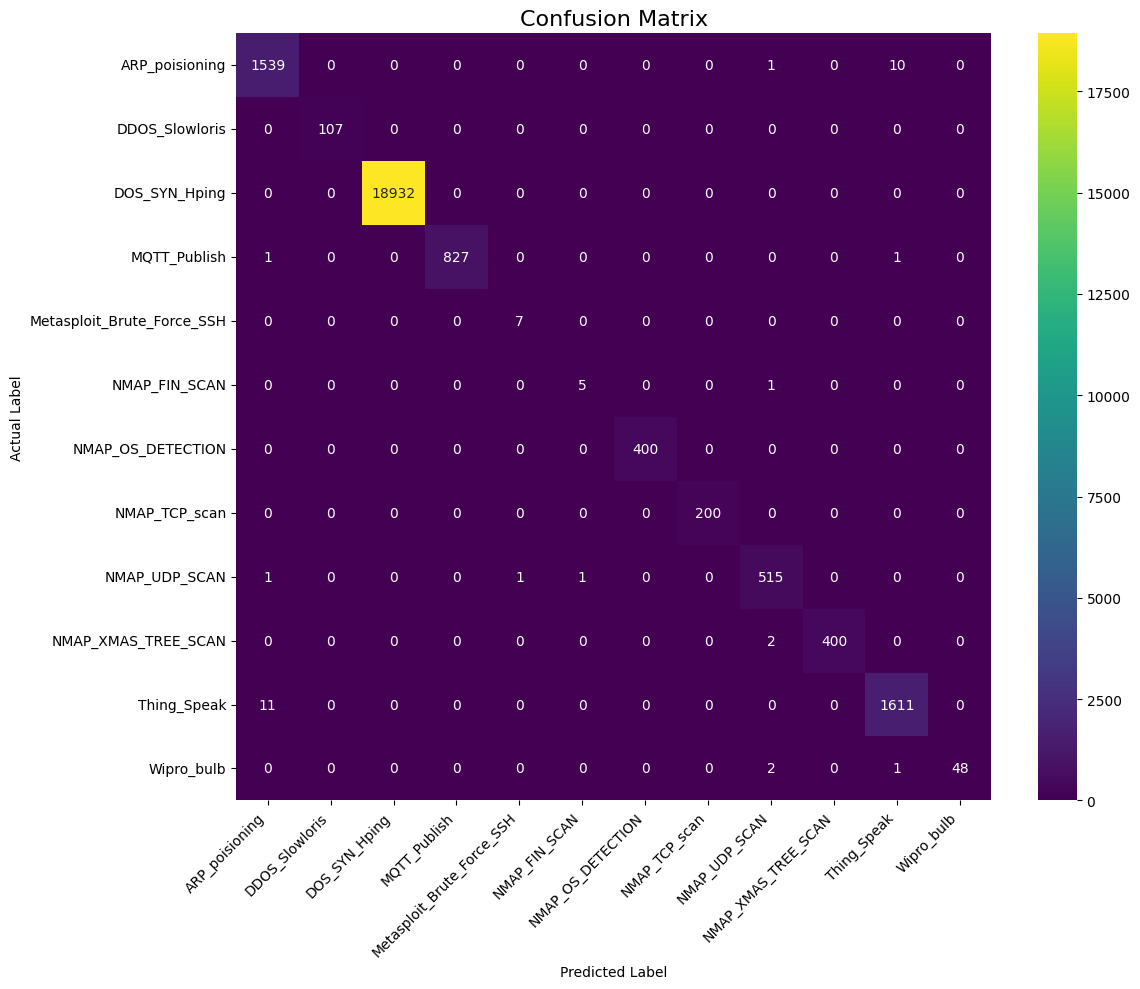

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()